In [1]:
from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.nn import conv2d

In [21]:
cnn = MnistCnn()
cnn.loadWeights('mnist_cnn/MnistCnnTEST')

(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255
print(img_data.shape)

(60000, 28, 28, 1)


In [4]:
def second_moment(hist, normalized): #E(X^2)
    sum = 0
    for i in range(hist.shape[0]):
        sum += (i*i*hist[i])
    result = sum / hist.sum()
    if(normalized):
        result = result/(255**2)
    return result
#var would be E((X-mu)^2)

In [5]:
# compute the binary map of an image
# if the gray-level of a pixel is below the threshold it becomes 0, otherwise 1
# using the square-root of the second moment of the image as a threshold
def computeBinaryMap(img, normalized):
    width = img.shape[0]
    height = img.shape[1]
    threshold = math.sqrt(second_moment(np.histogram(img, bins = 255)[0], normalized))
    newImg = np.zeros([width, height], np.int32)
    for i in range(width):
        for j in range(height):
            if(img[i,j] < threshold):
                newImg[i,j] = 0
            else:
                newImg[i,j] = 1
    return newImg

In [6]:
# compute U by counting the edges between 0s and 1s in the binary map
# done with a conv2D
def computeU(binMap):
    kernel1 = np.array([[-1,1]], np.int32)
    kernel1 = np.expand_dims(kernel1, -1)
    kernel1 = np.expand_dims(kernel1, -1)
    #print(kernel1.shape)
    kernel2 = np.array([[-1],[1]], np.int32)
    kernel2 = np.expand_dims(kernel2, -1)
    kernel2 = np.expand_dims(kernel2, -1)
    #print(kernel2.shape)
    horizU = conv2d(binMap, kernel1, strides = (1,1,1,1), padding = 'VALID')
    vertU = conv2d(binMap, kernel2, strides = (1,1,1,1), padding = 'VALID')
    horizU = tf.abs(horizU)
    vertU = tf.abs(vertU)
    hSum = tf.reduce_sum(horizU)
    vSum = tf.reduce_sum(vertU)
    return hSum + vSum

In [7]:
image = img_data[0]
#normalized_img = img_data[0] / 255
hist = np.histogram(image, bins = 255)
#hist_norm = np.histogram(normalized_img, bins = 255)
#hist1 = histogram(image)
#print(hist[1])
#print(hist_norm[1])
#print(hist1)

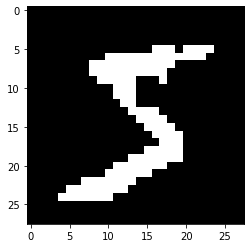

In [8]:
binary_img = computeBinaryMap(image, normalized = True)
#binary_normalized_img = computeBinaryMap(normalized_img, normalized = True)

#_, ax = plt.subplots(1, 2, figsize = (4,4))
#ax[0].imshow(binary_img, cmap = 'gray')
#ax[1].imshow(binary_normalized_img, cmap = 'gray')
plt.imshow(binary_img, cmap = 'gray')

In [9]:
dim = img_data.shape[0]
whitespaces = np.zeros([dim], np.float32)
unglaette = np.zeros([dim], np.float32)
for i in range(dim):
    whitespaces[i] = np.sum(img_data[i])
    binaryImg = computeBinaryMap(img_data[i], normalized = True)
    binaryImg_ = np.expand_dims(np.expand_dims(binaryImg, 0), -1)
    unglaette[i] = computeU(binaryImg_)
print(whitespaces[0:10])
print(unglaette[0:10])

[107.94118  121.94118   76.247055  67.196075  91.03529  116.08235
  69.2      140.6549    42.64314   85.89804 ]
[114. 124. 106.  64. 104. 130.  52. 112.  50. 106.]


/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


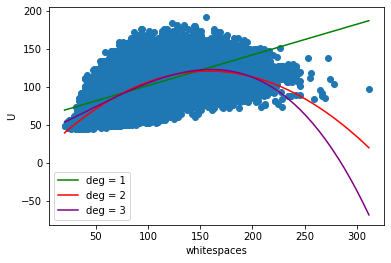

In [10]:
plt.scatter(x = whitespaces, y = unglaette)
plt.xlabel('whitespaces')
plt.ylabel('U')

p1 = np.poly1d(np.polyfit(whitespaces, unglaette, 1))
p2 = np.poly1d(np.polyfit(whitespaces, unglaette, 2))
p3 = np.poly1d(np.polyfit(whitespaces, unglaette, 3))

pLine = np.linspace(np.min(whitespaces), np.max(whitespaces), 50, dtype = np.float32)

plt.plot(pLine, p1(pLine), color = 'green')
plt.plot(pLine, p2(pLine), color = 'red')
plt.plot(pLine, p3(pLine), color = 'purple')

plt.legend(['deg = 1', 'deg = 2', 'deg = 3'])

plt.show()

In [11]:
print(p1.c.tolist())
print(p2.c.tolist())
print(p3.c.tolist())

p1_coeffs = p1.c.tolist()
p2_coeffs = p2.c.tolist()
p3_coeffs = p3.c.tolist()

print(p1_coeffs)
print(p2_coeffs)
print(p3_coeffs)

[0.4041477932311679, 61.49870042389077]
[-0.0042759147313791695, 1.3508408451730647, 14.318143779304823]
[-1.6713372619336923e-05, 0.0021874508328819996, 0.5895046399856166, 41.24809126277165]
[0.4041477932311679, 61.49870042389077]
[-0.0042759147313791695, 1.3508408451730647, 14.318143779304823]
[-1.6713372619336923e-05, 0.0021874508328819996, 0.5895046399856166, 41.24809126277165]


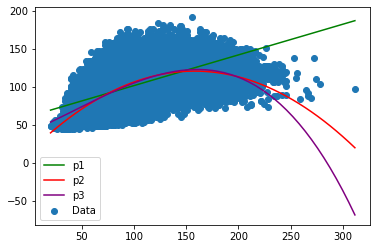

In [12]:
# recreate the plot using tf polynomials
plt.scatter(x = whitespaces, y = unglaette, label = 'Data')
plt.plot(pLine, tf.math.polyval(p1_coeffs, pLine), color = 'green', label = 'p1')
plt.plot(pLine, tf.math.polyval(p2_coeffs, pLine), color = 'red', label = 'p2')
plt.plot(pLine, tf.math.polyval(p3_coeffs, pLine), color = 'purple', label = 'p3')
plt.legend()

In [13]:
@tf.function
def g_orig(x, index, classifier, discriminator):
    res = tf.math.log(discriminator(x)) - tf.math.log(tf.squeeze(classifier(x))[index])
    return res

In [14]:
@tf.function
def g1(x, index, classifier):
    res = -tf.math.log(tf.squeeze(classifier(x))[index]) - tf.math.polyval(p1_coeffs, tf.math.reduce_sum(x))
    return res

In [15]:
@tf.function
def g2(x, index, classifier):
    res = -tf.math.log(tf.squeeze(classifier(x))[index]) - tf.math.polyval(p2_coeffs, tf.math.reduce_sum(x))
    return res

In [16]:
@tf.function
def g3(x, index, classifier):
    res = -tf.math.log(tf.squeeze(classifier(x))[index]) - tf.math.polyval(p3_coeffs, tf.math.reduce_sum(x))
    return res

In [17]:
def explain(x, classifier, maxIter, maxChange, minAlpha, target_function = g_orig):
    epsilon = 1e-16
    closeEnough = False
    iter = 0
    index = tf.argmax(tf.squeeze(classifier(x))).numpy()
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            res = target_function(x, index, classifier)
        grad = tape.gradient(res, x)
        maxGrad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(minAlpha, maxChange/tf.maximum(maxGrad, epsilon))
        x.assign(x + alpha * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if ((newIndex != index)): # done when the prediction has changed
            closeEnough = True
    print("done after ", iter, " steps")

done after  34  steps
done after  39  steps
done after  37  steps
done after  38  steps
done after  43  steps
done after  41  steps
done after  67  steps
done after  68  steps
done after  68  steps
done after  45  steps
done after  48  steps
done after  46  steps
done after  45  steps
done after  47  steps
done after  45  steps


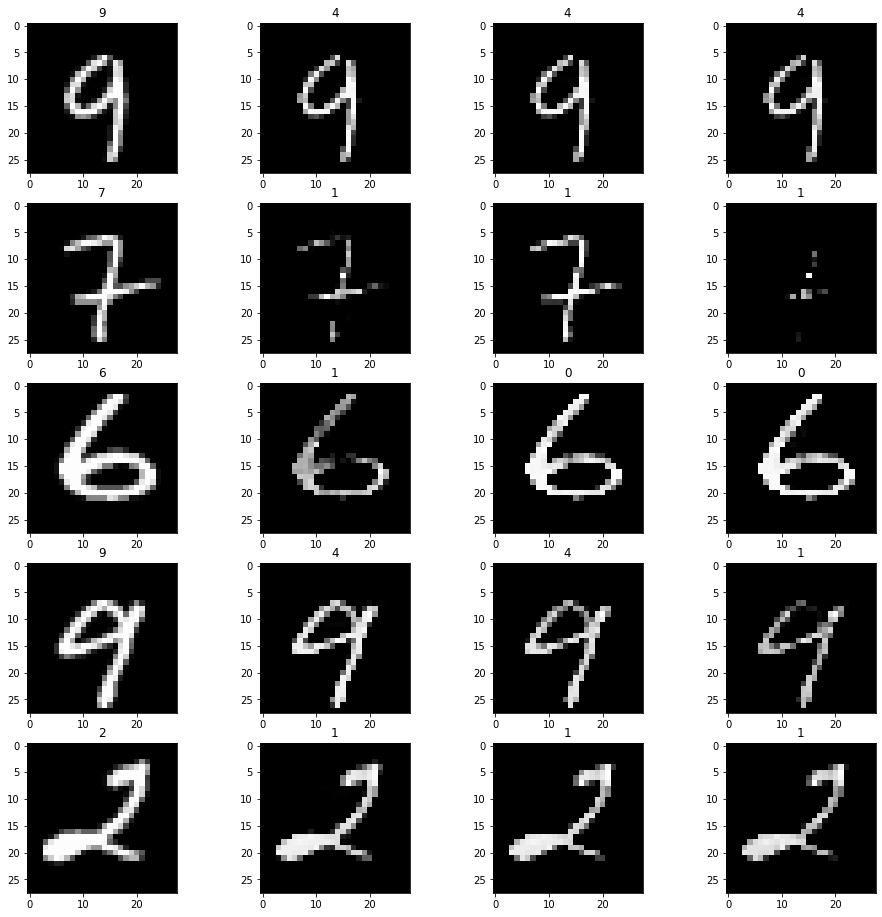

In [22]:
n_examples = 5
indices = np.random.randint(0, img_data.shape[0], n_examples)

_, ax = plt.subplots(n_examples, 4, figsize = (16, 16))

for i in range(len(indices)):
    img = img_data[indices[i]]
    x1 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    x2 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    x3 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
    explain(x1, cnn.model, 600, 0.0099, 1, target_function = g1)
    explain(x2, cnn.model, 600, 0.0099, 1, target_function = g2)
    explain(x3, cnn.model, 600, 0.0099, 1, target_function = g3)
    ax[i, 0].imshow(img, cmap = 'gray')
    title0 = str(tf.argmax(tf.squeeze(cnn.model(np.expand_dims(img,0)))).numpy())
    ax[i, 0].set_title(title0)
    ax[i, 1].imshow(x1[0], cmap = 'gray')
    title1 = str(tf.argmax(tf.squeeze(cnn.model(x1))).numpy())
    ax[i, 1].set_title(title1)
    ax[i, 2].imshow(x2[0], cmap = 'gray')
    title2 = str(tf.argmax(tf.squeeze(cnn.model(x2))).numpy())
    ax[i, 2].set_title(title2)
    ax[i, 3].imshow(x3[0], cmap = 'gray')
    title3 = str(tf.argmax(tf.squeeze(cnn.model(x3))).numpy())
    ax[i, 3].set_title(title3)